In [1]:
# 原文：http://pytorch123.com/ThirdSection/DataLoding/#pytorch
# 1.下载安装包
# scikit-image：用于图像的IO和变换
# pandas：用于更容易地进行csv解析

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd              #用于更容易地进行csv解析
from skimage import io, transform    #用于图像的IO和变换
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# 下载数据集放在'data/face'中，
# 这个数据集实际上是imagenet数据集标注为face的图片当中在 dlib 面部检测 (dlib’s pose estimation) 表现良好的图片。
# 我们要处理的是一个面部姿态的数据集。
# 数据集是按如下规则打包成的csv文件:
# image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y

In [3]:
# 将csv中的标注点数据读入（N，2）数组中，其中N是特征点的数量。读取数据代码如下：
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 32
img_name = landmarks_frame.iloc[n, 0]
# values将Series作为ndarry或者ndarry-like类型的数据返回，取决于dtype类型. 这句代码取出了第n张图片的所以标记点信息
landmarks = landmarks_frame.iloc[n, 1:].values
# 一对一对的坐标，2个一组
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 3074791551_baee7fa0c1.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[187. 160.]
 [186. 179.]
 [188. 198.]
 [193. 216.]]


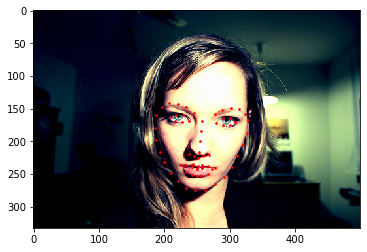

In [5]:
# 展示一张图片和它对应的标注点作为例子。用到的函数都很容易看出作用
def show_landmarks(image, landmarks):
    """显示带有地标的图片"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

In [6]:
# 5.数据集类
# torch.utils.data.Dataset是表示数据集的抽象类，因此自定义数据集应继承Dataset并覆盖以下方法 
# * __len__ 实现 len(dataset) 返还数据集的尺寸。
# * __getitem__用来获取一些索引数据，例如 dataset[i] 中的(i)。

In [7]:
# 为面部数据集创建一个数据集类。
# 我们将在 __init__中读取csv的文件内容，在 __getitem__中读取图片。
# 这么做是为了节省内存 空间。只有在需要用到图片的时候才读取它而不是一开始就把图片全部存进内存里。

In [8]:
# 我们的数据样本将按这样一个字典{'image': image, 'landmarks': landmarks}组织。 
# 我们的数据集类将添加一个可选参数transform 以方便对样本进行预处理。
#下一节我们会看到什么时候需要用到transform参数。 __init__方法如下图所示：
# 这部分代码也没什么值得说的
class FaceLandmarksDataset(Dataset):
    """面部标记数据集."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        csv_file（string）：带注释的csv文件的路径。
        root_dir（string）：包含所有图像的目录。
        transform（callable， optional）：一个样本上的可用的可选变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


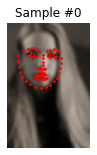

1 (500, 333, 3) (68, 2)


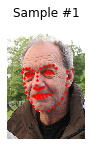

2 (250, 258, 3) (68, 2)


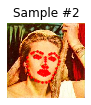

3 (434, 290, 3) (68, 2)


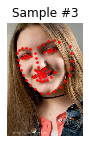

In [9]:
# 6.数据可视化
# 实例化这个类并遍历数据样本。我们将会打印出前四个例子的尺寸并展示标注的特征点。 代码如下图所示：
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    # 创建子图，1行4列，最后一个参数为当前图编号 但也不知道为什么没成功，还是画成了4行1列
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    # 不画坐标轴
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


In [10]:
# 数据变换
# 通过上面的例子我们会发现图片并不是同样的尺寸。绝大多数神经网络都假定图片的尺寸相同。因此我们需要做一些预处理。
# 让我们创建三个转换: * Rescale：缩放图片 * RandomCrop：对图片进行随机裁剪。这是一种数据增强操作 * ToTensor：把numpy格式图片转为torch格式图片 (我们需要交换坐标轴).
# 我们会把它们写成可调用的类的形式而不是简单的函数，这样就不需要每次调用时传递一遍参数。我们只需要实现__call__方法，必 要的时候实现 __init__方法。我们可以这样调用这些转换:
# tsfm = Transform(params)
# transformed_sample = tsfm(sample)

In [15]:
class Rescale(object):
    """将样本中的图像重新缩放到给定大小。.

    Args:
        output_size（tuple或int）：所需的输出大小。 如果是元组，则输出为
         与output_size匹配。 如果是int，则匹配较小的图像边缘到output_size保持纵横比相同。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            # output_size为int，将长或宽中小的那一个rescale成output_size，另一个保持纵横比缩放
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        
        # 看来skimage的这个库实现了对图片的各种转换操作
        img = transform.resize(image, (new_h, new_w))

        # 别忘了对landmarks也要作同样比例的缩放！
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """随机裁剪样本中的图像.

    Args:
       output_size（tuple或int）：所需的输出大小。 如果是int，就按照int的值进行方形裁剪。         
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        # 随机从图片中裁剪一块目标大小的图像出来,landmark也作相应处理 PS:h更小肿么办
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """将样本中的ndarrays转换为Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 交换颜色轴因为
        # numpy包的图片是: H * W * C
        # torch包的图片是: C * H * W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [16]:
# 8.组合转换
# 即把这些转换应用起来

In [17]:
# 我们想要把图像的短边调整为256，然后随机裁剪(randomcrop)为224大小的正方形。
# 也就是说，我们打算组合一个Rescale和 RandomCrop的变换。 
# 我们可以调用一个简单的类 torchvision.transforms.Compose来实现这一操作。具体实现如下图：

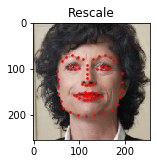

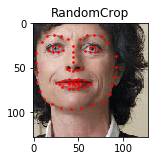

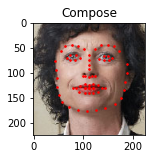

In [45]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# 在样本上应用上述的每个变换。
fig = plt.figure()
sample = face_dataset[65]

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [46]:
# 9.迭代数据集
# 让我们把这些整合起来以创建一个带组合转换的数据集。
# 总结一下，每次这个数据集被采样时: 
# * 及时地从文件中读取图片 * 对读取的图片应用转换 * 由于其中一步操作是随机的 (randomcrop) , 数据被增强了

# 我们可以像之前那样使用for i in range循环来对所有创建的数据集执行同样的操作。

In [47]:
# 还记得FaceLandmarksDataset 这个类吗，忘了可以翻回去看一下
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [58]:
# 但是，对所有数据集简单的使用for循环牺牲了许多功能，尤其是: * 批量处理数据 * 打乱数据 * 使用多线程multiprocessingworker 并行加载数据。
# torch.utils.data.DataLoader是一个提供上述所有这些功能的迭代器。
# 下面使用的参数必须是清楚的。一个值得关注的参数是collate_fn, 可以通过它来决定如何对数据进行批处理。但是绝大多数情况下默认值就能运行良好。
# PS: 这里windows下跑是有问题的，因为windows在用这个多线程方法时有内存泄漏，详情：https://github.com/pytorch/pytorch/pull/5585
# 概括点来说就是，因为在Windows上使用FileMapping（mmap）的差异引起的。
# Windows上，所有相关线程都释放了FileMapping对象的引用，它才才能够被释放。没有提供其他方法可以将其直接删除。（例如shm_unlink） 
# 启用多线程后，子线程将创建一个FileMapping，然后主进程将其打开。之后子线程将尝试释放它，但是它的引用计数非零，因此无法在那时释放它。
# 而且当前代码无法提供在可能的情况下再次关闭的机会，于是导致了内存泄漏。

# 解决办法是权宜之计，即使用num_workers参数，令num_workers=0,只使用一个主线程加载数据集。避免在windows中使用多线程。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


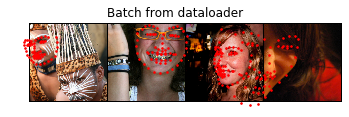

In [59]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# 辅助功能：显示批次
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')
        
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # 观察第4批次并停止。
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [60]:
# 10.后记：torchvision

In [61]:
# 在这篇教程中我们学习了如何构造和使用数据集类(datasets),转换(transforms)和数据加载器(dataloader)。
# torchvision包提供了 常用的数据集类(datasets)和转换(transforms)。
# 你可能不需要自己构造这些类。torchvision中还有一个更常用的数据集类ImageFolder。 它假定了数据集是以如下方式构造的:
"""
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
"""
# 其中'ants’,bees’等是分类标签。在PIL.Image中你也可以使用类似的转换(transforms)例如
# RandomHorizontalFlip,Scale。利 用这些你可以按如下的方式创建一个数据加载器(dataloader) :

'\nroot/ants/xxx.png\nroot/ants/xxy.jpeg\nroot/ants/xxz.png\n.\n.\n.\nroot/bees/123.jpg\nroot/bees/nsdf3.png\nroot/bees/asd932_.png\n'

In [62]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'hymenoptera_data/train'